In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from lightgbm import LGBMClassifier

In [76]:
from tqdm import tqdm

In [67]:
# Загрузка датасета
t = pd.read_parquet('transaction_fraud_data.parquet')
c = pd.read_parquet('historical_currency_exchange.parquet')

In [68]:
# Отсортируем данные по времени, чтобы в дальнейшем учесть временную природу данных
t = t.sort_values('timestamp')

In [42]:
# t.head()

In [46]:
# Доля мошенничества
fraud_rate = transactions['is_fraud'].mean()
print(f"Общий процент мошенничества: {fraud_rate:.2%}")

Общий процент мошенничества: 19.97%


In [88]:
# Видим, что выборка несбалансированна. Скорее всего это повлечет в дальнейшем необходимость
# установки больших весов для положительных объектов, чем для отрицательных в расчете information gain 
# при построении GBDT (да, будем строить градиентный бустинг) или корректировки
# порога классификации для максимизации интересующих нас метрик

In [69]:
# Преобразуем дату и индексы
t['date'] = t['timestamp'].dt.date
c = c.set_index('date')
# Разворачиваем курсы: long формата date,currency,rate
rates = c.stack().reset_index().rename(columns={'level_1':'currency', 0:'rate'})
# Объединяем и считаем amount_usd векторно
t = t.merge(rates, on=['date','currency'], how='left')
# Конвертируем основные суммы
t['amount_usd'] = t['amount'] / t['rate']

# Конвертация сумм из last_hour_activity: total_amount и max_single_amount
lha = pd.json_normalize(t['last_hour_activity']).add_prefix('lha_')
# применяем rate для lha_total_amount и lha_max_single_amount
lha['lha_total_amount_usd'] = lha['lha_total_amount'] / t['rate'].values
lha['lha_max_single_amount_usd'] = lha['lha_max_single_amount'] / t['rate'].values

# Объединяем, удаляем лишние
t = pd.concat([t.drop(columns=['rate']), lha], axis=1)

In [70]:
# Переведём нужные колонки в категориальный тип для LightGBM
cat_feats = ['device','vendor_category', 'vendor_type', 'channel', 'country',
             'city', 'city_size', 'card_type', 'currency']
for c in cat_feats:
    t[c] = t[c].astype('category')

# Формируем матрицу признаков и целевой вектор
features = [
    'amount_usd', 'is_card_present', 'is_outside_home_country',
    'is_high_risk_vendor', 'is_weekend',
    'lha_num_transactions', 'lha_total_amount_usd', 'lha_max_single_amount_usd',
    'lha_unique_merchants', 'lha_unique_countries'
] + cat_feats
X = t[features]
y = t['is_fraud']

In [71]:
# Сформируем разделение на train, val и test, учитывая время. Сплит будет 70%, 15%, 15%
n = len(t)
train_end, val_end = int(0.7*n), int(0.85*n)
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

In [72]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train, categorical_feature=cat_feats)

[LightGBM] [Info] Number of positive: 1051157, number of negative: 4187479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 5238636, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200655 -> initscore=-1.382207
[LightGBM] [Info] Start training from score -1.382207


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
# model = LGBMClassifier(random_state=42)
# param_dist = {
#     'n_estimators': [100,300,500],
#     'learning_rate': [0.2,0.1,0.05],
#     'max_depth': [4,6,8],
#     'colsample_bytree': [0.6,0.8,1.0]
# }
# rs = RandomizedSearchCV(
#     model, param_dist, n_iter=20,
#     cv=TimeSeriesSplit(3), scoring='recall', n_jobs=-1, random_state=42
# )
# rs.fit(X_train, y_train, categorical_feature=cat_feats)
# print('Best params:', rs.best_params_)

In [73]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['legit','fraud']))
print('Recall test:', recall_score(y_val, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

       legit       0.98      0.99      0.99    891482
       fraud       0.97      0.94      0.95    231083

    accuracy                           0.98   1122565
   macro avg       0.98      0.96      0.97   1122565
weighted avg       0.98      0.98      0.98   1122565

Recall test: 0.9353003033542061
Confusion matrix:
 [[884280   7202]
 [ 14951 216132]]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:30<00:00,  3.14it/s]C:\Users\user\anaconda3\envs\itmo_maga\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:31<00:00,  3.24it/s]


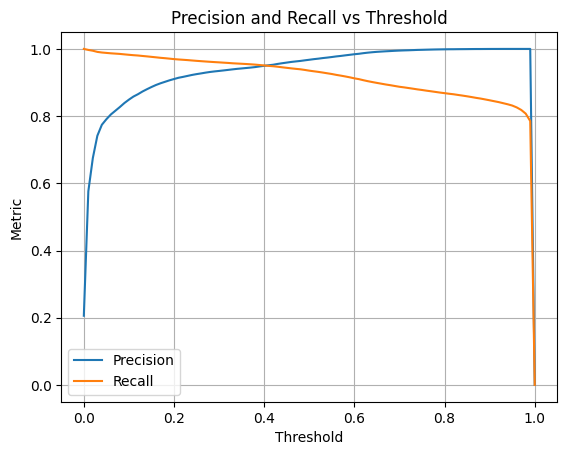

In [77]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Предсказанные вероятности на валидации
proba = model.predict_proba(X_val)[:, 1]

# Подготовка списков для метрик
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for th in tqdm(thresholds):
    preds = (proba >= th).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

# Построение графика
plt.figure()
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Воспользуемся порогом 0.2, основываясь на результатах вышепостроенного графика
# и замерим заново точность на валидационной выборке
y_pred = model.predict_proba(X_val)[:, 1] > 0.2
print(classification_report(y_val, y_pred, target_names=['legit','fraud']))
print('Recall test:', recall_score(y_val, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

       legit       0.99      0.98      0.98    891482
       fraud       0.91      0.97      0.94    231083

    accuracy                           0.97   1122565
   macro avg       0.95      0.97      0.96   1122565
weighted avg       0.98      0.97      0.97   1122565

Recall test: 0.9696818891913295
Confusion matrix:
 [[869424  22058]
 [  7006 224077]]


In [84]:
# Окончательная оценка качества модели на тестовой выборке, чтобы исключить переобучение
# из-за подбора порога на валидации
y_pred = model.predict_proba(X_test)[:, 1] > 0.2
print(classification_report(y_test, y_pred, target_names=['legit','fraud']))
print('Recall test:', recall_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       legit       0.99      0.97      0.98    910086
       fraud       0.90      0.97      0.93    212479

    accuracy                           0.97   1122565
   macro avg       0.95      0.97      0.96   1122565
weighted avg       0.98      0.97      0.97   1122565

Recall test: 0.9703076539328592
Confusion matrix:
 [[886843  23243]
 [  6309 206170]]


In [87]:
# Потеряв немного в precision получаем хороший recall, равный 97% на тестовой выборке. 
# Максимизация Recall нужна для того, чтобы не пропустить мошеннические операции, вес
# ошибки на которых очевидно больше, чем вес ошибки на валидных операциях
# (Нам важнее не пропустить мошеннические операции, чем ошибочно заблокировать валидные, так как 
# блокировка валидных операций обернется лишь дополнительным звонком в банк от
# пользователя и дополнительной проверкой действительно ли он делает перевод, когда мошенническая операция 
# обернется трагичными последствиями для пользователя)